In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat

In [2]:
# @title Plotting Functions

def plot_stim_and_spikes(stim, spikes, dt, nt=120):
  """Show time series of stim intensity and spike counts.

  Args:
    stim (1D array): vector of stimulus intensities
    spikes (1D array): vector of spike counts
    dt (number): duration of each time step
    nt (number): number of time steps to plot

  """
  timepoints = np.arange(nt)
  time = timepoints * dt

  f, (ax_stim, ax_spikes) = plt.subplots(
    nrows=2, sharex=True, figsize=(8, 5),
  )
  ax_stim.plot(time, stim[timepoints])
  ax_stim.set_ylabel('Stimulus intensity')

  ax_spikes.plot(time, spikes[timepoints])
  ax_spikes.set_xlabel('Time (s)')
  ax_spikes.set_ylabel('Number of spikes')

  f.tight_layout()
  plt.show()


def plot_glm_matrices(X, y, nt=50):
  """Show X and Y as heatmaps.

  Args:
    X (2D array): Design matrix.
    y (1D or 2D array): Target vector.

  """
  from matplotlib.colors import BoundaryNorm
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  Y = np.c_[y]  # Ensure Y is 2D and skinny

  f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(6, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )
  norm = BoundaryNorm([-1, -.2, .2, 1], 256)
  imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)

  ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    xticks=[4, 14, 24],
    xticklabels=['-20', '-10', '0'],
    ylabel="Time point (time bins)",
  )
  plt.setp(ax_x.spines.values(), visible=True)

  divx = make_axes_locatable(ax_x)
  caxx = divx.append_axes("right", size="5%", pad=0.1)
  cbarx = f.colorbar(imx, cax=caxx)
  cbarx.set_ticks([-.6, 0, .6])
  cbarx.set_ticklabels(np.sort(np.unique(X)))

  norm = BoundaryNorm(np.arange(y.max() + 1), 256)
  imy = ax_y.pcolormesh(Y[:nt], cmap="magma", norm=norm)
  ax_y.set(
    title="Y\n(spike count)",
    xticks=[]
  )
  ax_y.invert_yaxis()
  plt.setp(ax_y.spines.values(), visible=True)

  divy = make_axes_locatable(ax_y)
  caxy = divy.append_axes("right", size="30%", pad=0.1)
  cbary = f.colorbar(imy, cax=caxy)
  cbary.set_ticks(np.arange(y.max()) + .5)
  cbary.set_ticklabels(np.arange(y.max()))
  plt.show()


def plot_spike_filter(theta, dt, show=True, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()
    show (boolean): To plt.show or not the plot.
  """
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )
  if show:
    plt.show()


def plot_spikes_with_prediction(spikes, predicted_spikes, dt,
                                nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    show (boolean): To plt.show or not the plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt])
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  plt.show()

In [3]:
# @title Data retrieval and loading
import os
import hashlib
import requests

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
data = loadmat('RGCdata.mat')  # loadmat is a function in scipy.io
dt_stim = data['dtStim'].item()  # .item extracts a scalar value

# Extract the stimulus intensity
stim = data['Stim'].squeeze()  # .squeeze removes dimensions with 1 element

# Extract the spike counts for one cell
cellnum = 2
spikes = data['SpCounts'][:, cellnum]

# Don't use all of the timepoints in the dataset, for speed
keep_timepoints = 20000
stim = stim[:keep_timepoints]
spikes = spikes[:keep_timepoints]

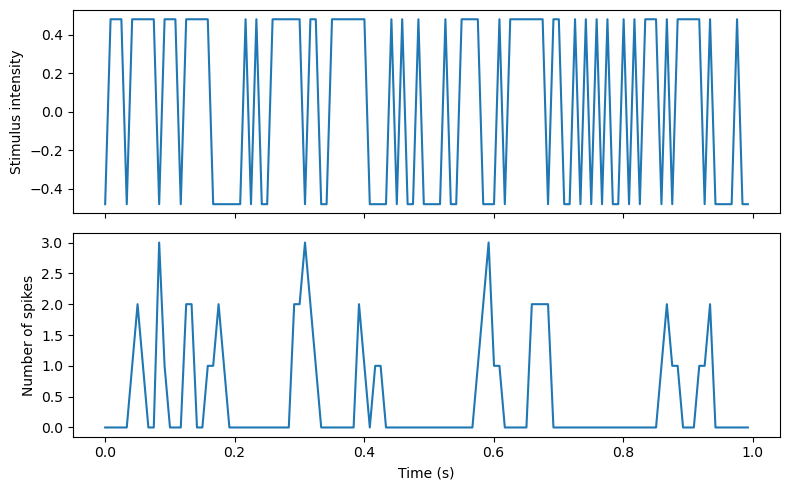

In [5]:
plot_stim_and_spikes(stim, spikes, dt_stim)

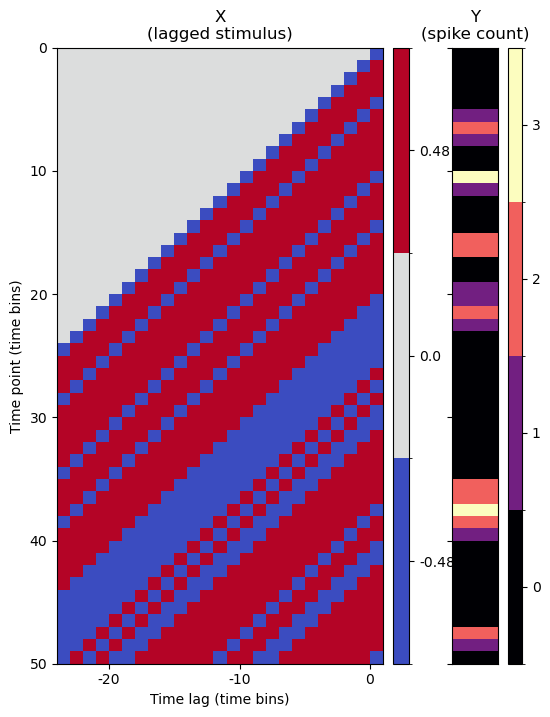

In [6]:
def make_design_matrix(stim, d=25):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  """

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  #####################################################################
  # Fill in missing code (...),
  # then remove or comment the line below to test your function
  #####################################################################


  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t+d]

  return X


# Make design matrix
X = make_design_matrix(stim)

# Visualize
plot_glm_matrices(X, spikes, nt=50)

In [7]:
# Build the full design matrix
y = spikes
constant = np.ones_like(y)
X = np.column_stack([constant, make_design_matrix(stim)])

# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta_lg = theta[1:]

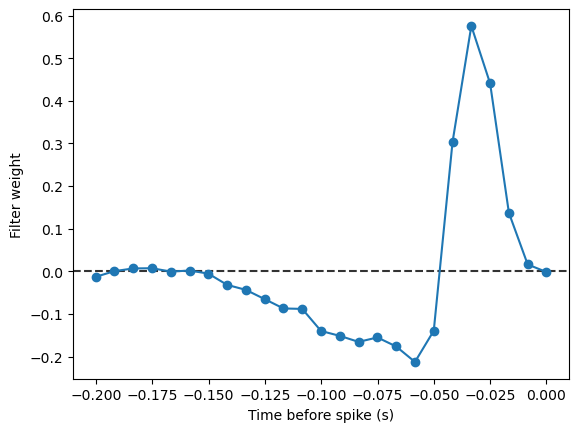

In [8]:
plot_spike_filter(theta_lg, dt_stim)

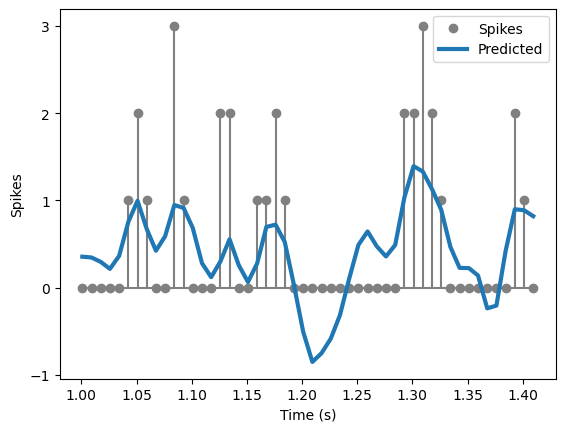

In [9]:
def predict_spike_counts_lg(stim, spikes, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """
  ##########################################################################
  # Fill in missing code (...) and then comment or remove the error to test
  ##########################################################################

  # Create the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Get the MLE weights for the LG model
  theta = np.linalg.inv(X.T @ X) @ X.T @ y

  # Compute predicted spike counts
  yhat = X @ theta

  return yhat


# Predict spike counts
predicted_counts = predict_spike_counts_lg(stim, spikes)

# Visualize
plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)

In [10]:
f = np.square
res = minimize(f, x0=2)
print(f"Minimum value: {res['fun']:.4g} at x = {res['x'].item():.5e}")

Minimum value: 3.566e-16 at x = -1.88846e-08


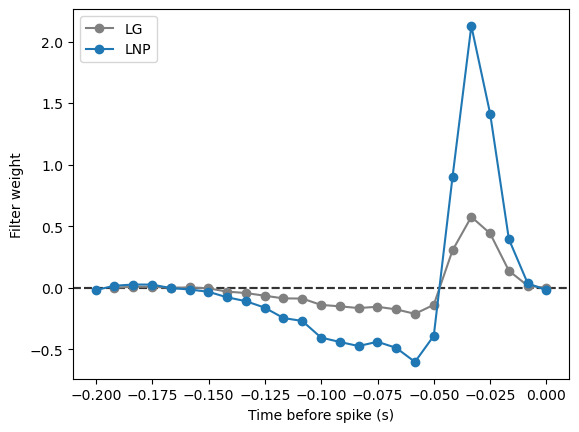

In [11]:
def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """
  #####################################################################
  # Fill in missing code (...), then remove the error
  #####################################################################

  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()

  return -log_lik


def fit_lnp(stim, spikes, d=25):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """
  #####################################################################
  # Fill in missing code (...), then remove the error
  #####################################################################

  # Build the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y))

  return res["x"]


# Fit LNP model
theta_lnp = fit_lnp(stim, spikes)

# Visualize
plot_spike_filter(theta_lg[1:], dt_stim, show=False, color=".5", label="LG")
plot_spike_filter(theta_lnp[1:], dt_stim, show=False, label="LNP")
plt.legend(loc="upper left")
plt.show()

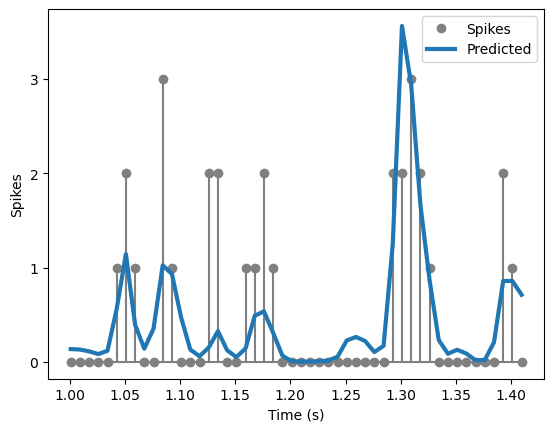

In [13]:
def predict_spike_counts_lnp(stim, spikes, theta=None, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    theta (1D array): Filter weights; estimated if not provided.
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """
  ###########################################################################
  # Fill in missing code (...) and then remove the error to test
  ###########################################################################

  y = spikes
  constant = np.ones_like(spikes)
  X = np.column_stack([constant, make_design_matrix(stim)])
  if theta is None:  # Allow pre-cached weights, as fitting is slow
    theta = fit_lnp(X, y, d)

  yhat = np.exp(X @ theta)
  return yhat


# Predict spike counts
yhat = predict_spike_counts_lnp(stim, spikes, theta_lnp)

# Visualize
plot_spikes_with_prediction(spikes, yhat, dt_stim)